In [27]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

from mplsoccer import Pitch, VerticalPitch, FontManager
from mplsoccer.statsbomb import read_event, EVENT_SLUG

rcParams['text.color'] = '#c7d5cc'  # set the default text color

# get event dataframe for game 7478, create a dataframe of the passes,
# and a boolean mask for the outcome
df = read_event(f'{EVENT_SLUG}/7478.json',
                related_event_df=False, shot_freeze_frame_df=False,
                tactics_lineup_df=False)['event']

In [44]:
team1, team2 = df.team_name.unique()
mask_team1 = (df.type_name == 'Pass') & (df.team_name == team1)

In [45]:
df_pass = df.loc[mask_team1, ['x', 'y', 'end_x', 'end_y', 'outcome_name']]
mask_complete = df_pass.outcome_name.isnull()

In [46]:
df_pass.head()

,x,y,end_x,end_y,outcome_name
20,11.0,80.0,29.0,68.0,NaN
22,29.0,67.0,58.0,80.0,Out
28,56.0,68.0,75.0,77.0,NaN
37,95.0,80.0,110.0,56.0,NaN
40,109.0,56.0,106.0,54.0,Incomplete


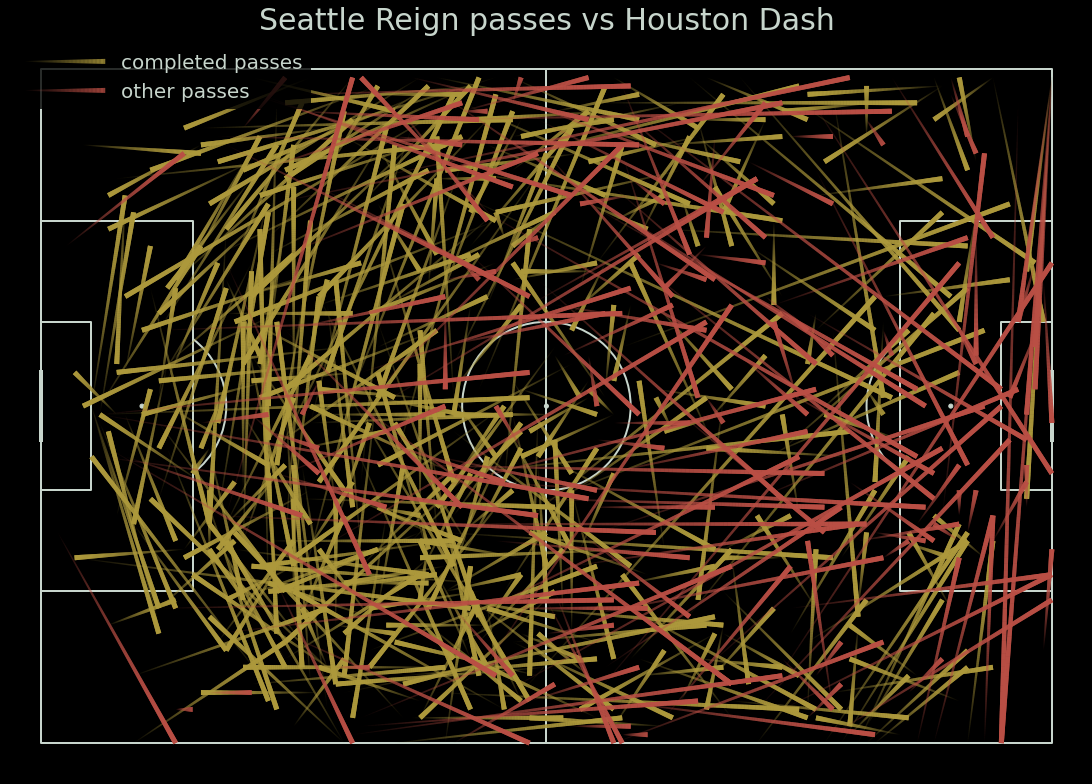

In [47]:
# Setup the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#000000', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#000000')

# Plot the completed passes
lc1 = pitch.lines(df_pass[mask_complete].x, df_pass[mask_complete].y,
                  df_pass[mask_complete].end_x, df_pass[mask_complete].end_y,
                  lw=5, transparent=True, comet=True, label='completed passes',
                  color='#ad993c', ax=ax)

# Plot the other passes
lc2 = pitch.lines(df_pass[~mask_complete].x, df_pass[~mask_complete].y,
                  df_pass[~mask_complete].end_x, df_pass[~mask_complete].end_y,
                  lw=5, transparent=True, comet=True, label='other passes',
                  color='#ba4f45', ax=ax)

# Plot the legend
ax.legend(facecolor='#000000', edgecolor='None', fontsize=20, loc='upper left', handlelength=4)

# Set the title
ax.set_title(f'{team1} passes vs {team2}', fontsize=30)
fig.savefig("all-passes-map", dpi=180) ##save image

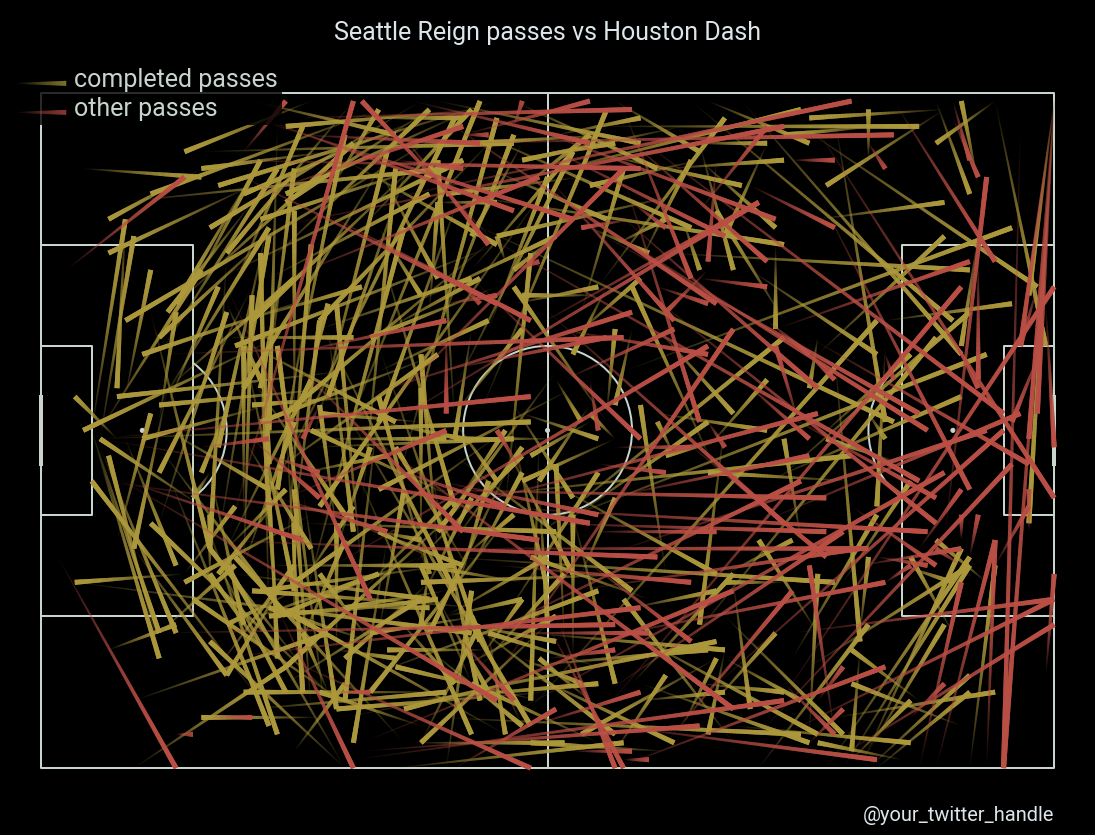

In [48]:
fig, axs = pitch.grid(endnote_height=0.03, endnote_space=0, figheight=12,
                      title_height=0.06, title_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      grid_height=0.86)
fig.set_facecolor('#000000')

# Plot the completed passes
lc1 = pitch.lines(df_pass[mask_complete].x, df_pass[mask_complete].y,
                  df_pass[mask_complete].end_x, df_pass[mask_complete].end_y,
                  lw=5, transparent=True, comet=True, label='completed passes',
                  color='#ad993c', ax=axs['pitch'])

# Plot the other passes
lc2 = pitch.lines(df_pass[~mask_complete].x, df_pass[~mask_complete].y,
                  df_pass[~mask_complete].end_x, df_pass[~mask_complete].end_y,
                  lw=5, transparent=True, comet=True, label='other passes',
                  color='#ba4f45', ax=axs['pitch'])

# fontmanager for google font (robotto)
robotto_regular = FontManager()

# setup the legend
legend = axs['pitch'].legend(facecolor='#000000', handlelength=5, edgecolor='None',
                             prop=robotto_regular.prop, loc='upper left')
for text in legend.get_texts():
    text.set_fontsize(25)

# endnote and title
axs['endnote'].text(1, 0.5, '@your_twitter_handle', va='center', ha='right', fontsize=20,
                    fontproperties=robotto_regular.prop, color='#dee6ea')
axs['title'].text(0.5, 0.5, f'{team1} passes vs {team2}', color='#dee6ea',
                  va='center', ha='center',
                  fontproperties=robotto_regular.prop, fontsize=25)

fig.savefig("all-passes-map-labelled", dpi=180) ##save image

In [49]:
TEAM1 = 'Seattle Reign'
TEAM2 = 'Houston Dash'
df_pass = df.loc[(df.pass_assisted_shot_id.notnull()) & (df.team_name == TEAM1),
                 ['x', 'y', 'end_x', 'end_y', 'pass_assisted_shot_id']]

df_shot = (df.loc[(df.type_name == 'Shot') & (df.team_name == TEAM1),
                  ['id', 'outcome_name', 'shot_statsbomb_xg']]
           .rename({'id': 'pass_assisted_shot_id'}, axis=1))

df_pass = df_pass.merge(df_shot, how='left').drop('pass_assisted_shot_id', axis=1)

mask_goal = df_pass.outcome_name == 'Goal'

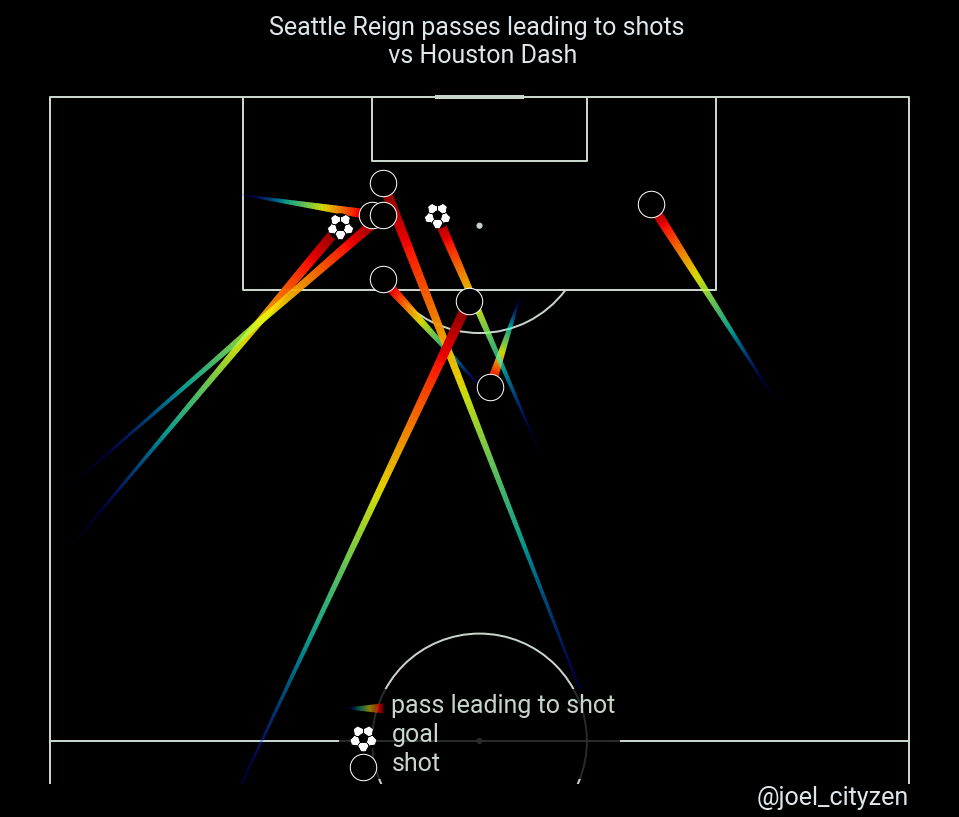

In [51]:
# Setup the pitch
pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='#000000', line_color='#c7d5cc',
                      half=True, pad_top=2)
fig, axs = pitch.grid(endnote_height=0.03, endnote_space=0, figheight=12,
                      title_height=0.08, title_space=0, axis=False,
                      grid_height=0.82)
fig.set_facecolor('#000000')

# Plot the completed passes
pitch.lines(df_pass.x, df_pass.y, df_pass.end_x, df_pass.end_y,
            lw=10, transparent=True, comet=True, cmap='jet',
            label='pass leading to shot', ax=axs['pitch'])

# Plot the goals
pitch.scatter(df_pass[mask_goal].end_x, df_pass[mask_goal].end_y, s=700,
              marker='football', edgecolors='black', c='white', zorder=2,
              label='goal', ax=axs['pitch'])
pitch.scatter(df_pass[~mask_goal].end_x, df_pass[~mask_goal].end_y,
              edgecolors='white', c='#000000', s=700, zorder=2,
              label='shot', ax=axs['pitch'])

# endnote and title
axs['endnote'].text(1, 0.5, '@joel_cityzen', va='center', ha='right', fontsize=25,
                    fontproperties=robotto_regular.prop, color='#dee6ea')
axs['title'].text(0.5, 0.5, f'{TEAM1} passes leading to shots \n vs {TEAM2}', color='#dee6ea',
                  va='center', ha='center',
                  fontproperties=robotto_regular.prop, fontsize=25)

# set legend
legend = axs['pitch'].legend(facecolor='#000000', edgecolor='None',
                             loc='lower center', handlelength=4)
for text in legend.get_texts():
    text.set_fontproperties(robotto_regular.prop)
    text.set_fontsize(25)

fig.savefig("selected-passes-map", dpi=180) ##save image